<a href="https://colab.research.google.com/github/vsinyutsina/deep_learning/blob/master/heh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import sklearn as sl
import matplotlib.pyplot as plt

### Загрузка файлов

In [0]:
train_data = pd.read_csv("/content/drive/My Drive/school-21-student-expulsion-prediction/train.csv")

In [151]:
train_data.head()

,id,Birth date,Native city,Gender,Wave id,Level,Heard about school from,Life status,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,evalexpr,match_n_match,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Contract termination date,Memory entrance game,Logic entrance game,contract_status
0,129212391,1990-01-18,Пермь,male,3,7.463235,google_ads,work,5,NaN,0.0,80.0,0.0,1.0,0.0,15.0,10.0,0.0,50.0,21.0,20.0,55.0,81.0,0.0,0.0,0.0,0.0,0.0,75.0,43.0,100.0,44.0,NaN,9,11,1
1,566688420,1996-07-31,Волгоград,female,1,8.785714,NaN,NaN,0,NaN,10.0,45.0,5.0,1.0,35.0,0.0,5.0,16.0,0.0,9.0,0.0,10.0,0.0,0.0,0.0,110.0,0.0,0.0,0.0,16.0,22.0,22.0,NaN,7,10,1
2,242300495,1992-06-27,Новосибирск,female,2,6.775000,other,work,0,NaN,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,16.0,27.0,NaN,7,11,1
3,715424753,1996-06-15,Тула,female,1,8.146104,NaN,NaN,5,0.0,35.0,25.0,20.0,2.0,70.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,27.0,NaN,9,6,1
4,382884118,1968-07-18,Голицыно,male,3,4.272727,other,other,0,0.0,NaN,5.0,85.0,3.0,50.0,40.0,0.0,12.0,40.0,5.0,0.0,0.0,0.0,60.0,0.0,120.0,0.0,0.0,80.0,38.0,0.0,45.0,NaN,7,12,1


In [0]:
test_data = pd.read_csv("/content/drive/My Drive/school-21-student-expulsion-prediction/test.csv")

In [153]:
test_data.head()

,id,Birth date,Native city,Gender,Wave id,Level,Heard about school from,Life status,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,evalexpr,match_n_match,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Contract termination date,Memory entrance game,Logic entrance game
0,685512434,1992-09-08,г. Тюмень,male,3,8.834416,google_ads,work,10,NaN,80.0,40.0,30.0,5.0,70.0,10.0,40.0,0.0,85.0,21.0,0.0,20.0,100.0,0.0,100.0,120.0,0.0,0.0,75.0,43.0,64.0,45.0,NaN,10,12
1,157712083,1993-12-02,Москва,male,2,2.172414,from_21_student,work,7,0.0,0.0,50.0,0.0,5.0,20.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,80.0,22.0,33.0,36.0,NaN,7,6
2,672158583,1989-02-16,Москва,male,3,4.310160,from_friends,other,5,0.0,0.0,5.0,10.0,-42.0,35.0,20.0,5.0,9.0,35.0,21.0,10.0,10.0,0.0,60.0,0.0,0.0,0.0,75.0,0.0,6.0,33.0,9.0,NaN,7,10
3,1205321261,1997-07-16,Дзержинский,female,2,6.295833,other,study,20,0.0,30.0,0.0,10.0,0.0,20.0,0.0,0.0,NaN,10.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,15.0,1.0,16.0,22.0,NaN,9,8
4,621191476,1997-02-22,Москва,male,1,7.110294,NaN,NaN,100,100.0,80.0,30.0,0.0,2.0,0.0,40.0,10.0,6.0,0.0,-42.0,0.0,15.0,0.0,60.0,100.0,0.0,0.0,0.0,65.0,65.0,54.0,36.0,NaN,9,15


In [0]:
sample_submission = pd.read_csv("/content/drive/My Drive/school-21-student-expulsion-prediction/sample_submission.csv")

In [155]:
sample_submission.head()

,id,contract_status
0,685512434,0
1,157712083,0
2,672158583,0
3,1205321261,0
4,621191476,0


### Обработка данных, генерация фичей

In [0]:
# не известны на момент выпуска из бассейна

del train_data['Contract termination date'], train_data['Level']
del test_data['Contract termination date'], test_data['Level']

# не нужно
del train_data['id']

###### Город рождения

In [0]:
from string import punctuation
from operator import itemgetter as at

def is_from_city(raw_city, city_names):
  return raw_city.fillna('NULL').str.split().map(at(-1)).str.strip(punctuation)\
                    .str.lower().str.replace('ё', 'e').isin(city_names)

moscow_names = ['москва', 'moscow']

moscow_suburbs = [
  'балашиха', 'мытищи', 'долгопрудный', 'красногорск',
  'реутов', 'люберцы', 'химки', 'одинцово', 'котельники',
  'подольск', 'железнодорожный', 'жуковский', 'королев'
]


for df in [train_data, test_data]:
  df['moscow_citizen'] = is_from_city(df['Native city'], moscow_names)
  df['from_moscow_suburb'] = is_from_city(df['Native city'], moscow_suburbs)
  df['Native city'].fillna('NULL', inplace=True)

##### Возраст

In [0]:
def get_age(birth_date):
  return (pd.to_datetime('2019-08-31') - pd.to_datetime(birth_date)).dt.days // 365


for df in [train_data, test_data]:
  df['age'] = get_age(df['Birth date'])
  df['over_32_yo'] = df['Birth date'] >= '1989-08-31'
  df['less_24_yo'] = df['Birth date'] <= '1996-08-31'
  del df['Birth date']

##### Данные об успеваемости

In [0]:
perfomance_columns = {
  'workday': df.columns[df.columns.str.startswith('day')].tolist(),
  'exam': ['exam_00', 'exam_01', 'exam_02'],
  'ind_ht': ['evalexpr', 'match_n_match', 'bsq'],
  'team_ht': ['rush_00', 'rush_01', 'rush_02'],
}

all_perfomance_cols = sum(perfomance_columns.values(), [])

for df in [train_data, test_data]:
  for ht_type, cols in perfomance_columns.items():
    df['%s_median_result' % ht_type] = df[cols].fillna(-100).apply(np.median, axis=1)
    df['%s_maximal_result' % ht_type] = df[cols].fillna(-100).apply(np.max, axis=1)
    df['%s_failed' % ht_type] = df[cols].isnull().sum(axis=1)
    df['%s_sum' % ht_type] = df[cols][df[cols] >= 0].sum(axis=1)
 
  df['successful_workdays'] = (df[perfomance_columns['workday']] >= 40).sum(axis=1)
  df['tasks_failed'] = (df[all_perfomance_cols].isnull()).sum(axis=1)
  df['has_cheated'] = (df[all_perfomance_cols] == -42).any(axis=1)
  # now we can fill nulls
  for col in all_perfomance_cols + ['exam_final']:
    df[col] = df[col].fillna(0)

##### Другое

In [130]:
train_data[train_data.columns[train_data.isnull().any(axis=0)]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 2 columns):
Heard about school from    653 non-null object
Life status                655 non-null object
dtypes: object(2)
memory usage: 16.7+ KB


Life status и heard about school from содержат больше половины пропусков. Необходимо определить их значимость.

##### Life status

In [0]:
train_data['Life status'].fillna('No info', inplace=True)

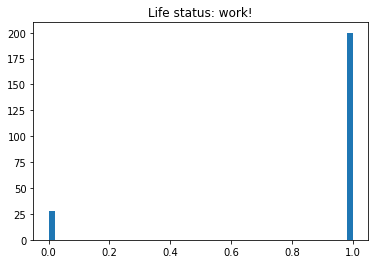

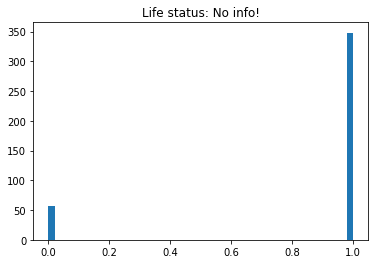

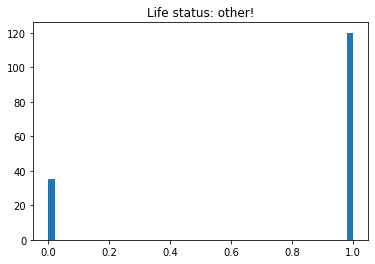

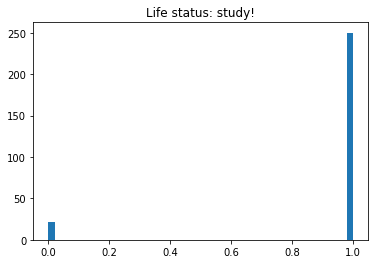

In [132]:
for status in train_data['Life status'].unique():
    current_data = train_data[train_data['Life status'] == status]
    plt.title('Life status: %s!' % status)
    plt.hist(current_data['contract_status'], bins=np.linspace(0, 1))
    plt.show()

Кажется, life status оказывал влияние на то, взяли человека или нет.

In [0]:
test_data['Life status'].fillna('No info', inplace=True)

##### Heard about school from

In [0]:
train_data['Heard about school from'].fillna('No info', inplace=True)

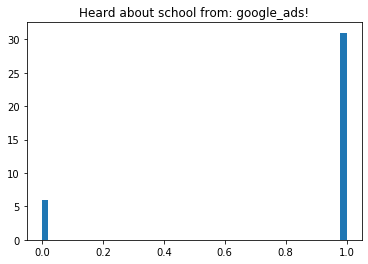

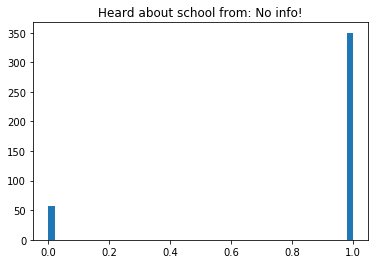

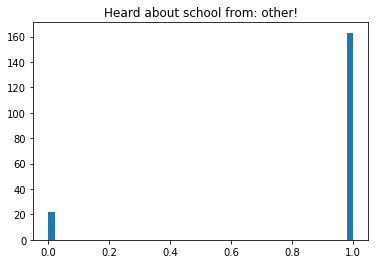

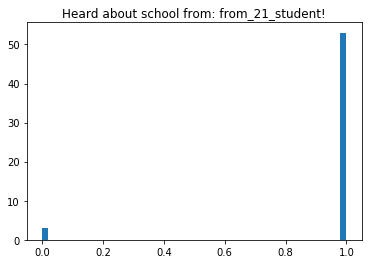

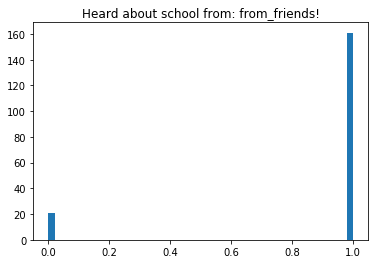

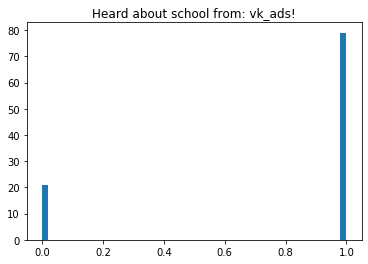

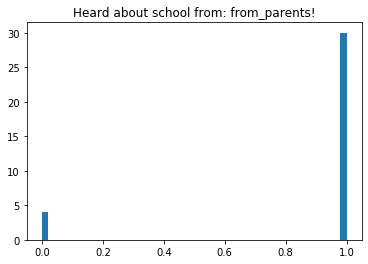

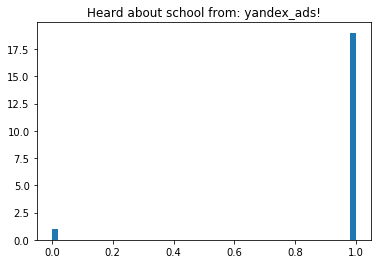

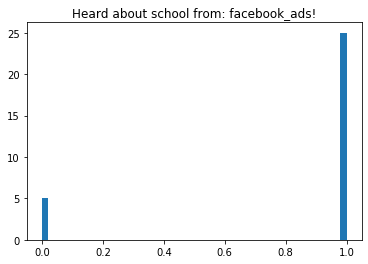

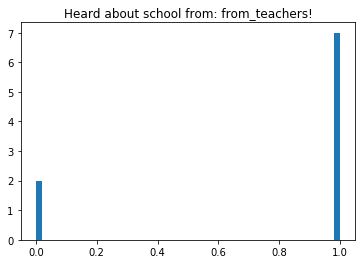

In [135]:
for status in train_data['Heard about school from'].unique():
    current_data = train_data[train_data['Heard about school from'] == status]
    plt.title('Heard about school from: %s!' % status)
    plt.hist(current_data['contract_status'], bins=np.linspace(0, 1))
    plt.show()

In [0]:
test_data['Heard about school from'].fillna('No info', inplace=True)

Assertion that data is alright

In [0]:
assert not train_data.isnull().any().any() and not test_data.isnull().any().any()

In [0]:
train_data['contract_status'] = train_data['contract_status'].astype(bool)

### Обучение

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
y_pred = train_data['contract_status']
del train_data['contract_status']

X_train, X_val, y_train, y_val = train_test_split(train_data, y_pred, train_size=0.8, random_state=42)

In [0]:
try:
  from catboost import CatBoostClassifier, Pool
except ModuleNotFoundError:
  !pip install catboost
  from catboost import CatBoostClassifier, Pool

In [0]:
cat_boost_params = {
    'task_type': 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'iterations': 10**5,
    'od_pval': 1e-5,
    'learning_rate': 0.01,
    'random_state': 41
}

In [0]:
#positive_proportion = y_train.shape[0] / y_train.sum()

#train_weights = [positive_proportion if label else 1 for label in y_train]

In [148]:
train = Pool(X_train, y_train) #cat_features=train_data.columns[train_data.dtypes == object].tolist(), weight=train_weights)
val = Pool(X_val, y_val) #cat_features=train_data.columns[train_data.dtypes == object].tolist())
test = Pool(test_data) #cat_features=train_data.columns[train_data.dtypes == object].tolist())

classifier = CatBoostClassifier(**cat_boost_params)

basemodel = classifier.fit(train, use_best_model=True, eval_set=val, verbose=250)

CatBoostError: ignored

### Предсказание

In [67]:
pred = basemodel.predict_proba(test)
pred

array([[0.125204  , 0.874796  ],
       [0.11306221, 0.88693779],
       [0.06781375, 0.93218625],
       ...,
       [0.06489679, 0.93510321],
       [0.06857379, 0.93142621],
       [0.06024003, 0.93975997]])

In [0]:
ans = pd.DataFrame()

ans['id'] = test_data['id']
ans['contract_status'] = pred[:, 1]

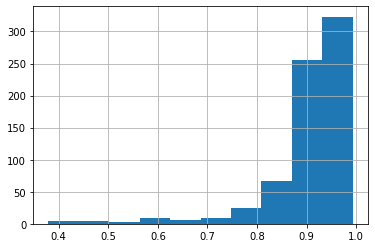

In [106]:
ans.contract_status.hist()

In [107]:
ans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706 entries, 0 to 705
Data columns (total 2 columns):
id                 706 non-null int64
contract_status    706 non-null float64
dtypes: float64(1), int64(1)
memory usage: 11.2 KB


In [109]:
ans.head()

,id,contract_status
0,685512434,0.874796
1,157712083,0.886938
2,672158583,0.932186
3,1205321261,0.886176
4,621191476,0.660445


In [76]:
sample_submission.head()

,id,contract_status
0,685512434,0
1,157712083,0
2,672158583,0
3,1205321261,0
4,621191476,0


In [77]:
from collections import Counter

Counter(ans['contract_status'])

Counter({0: 614, 1: 92})

In [0]:
ans.to_csv('float_prediction.csv', index=False)

In [79]:
sum(ans['id'] == sample_submission['id'])

706

### Попытка №2

In [0]:
import numpy as np
import pandas as pd
import sklearn as sl

In [0]:
train = pd.read_csv("/content/drive/My Drive/train_after_clean.csv")

In [83]:
train.head()

,Birth date,Native city,Gender,Wave id,Level,Life status,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,evalexpr,match_n_match,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game,contract_status
0,30,0,1,3,7.463235,1,5,0.0,0.0,80.0,0.0,1.0,0.0,15.0,10.0,0.0,50.0,21.0,20.0,55.0,81.0,0.0,0.0,0.0,0.0,0.0,75.0,43.0,100.0,44.0,9,11,1
1,23,0,0,1,8.785714,0,0,0.0,10.0,45.0,5.0,1.0,35.0,0.0,5.0,16.0,0.0,9.0,0.0,10.0,0.0,0.0,0.0,110.0,0.0,0.0,0.0,16.0,22.0,22.0,7,10,1
2,27,0,0,2,6.775000,1,0,0.0,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,27.0,7,11,1
3,23,0,0,1,8.146104,0,5,0.0,35.0,25.0,20.0,2.0,70.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,27.0,9,6,1
4,51,0,1,3,4.272727,0,0,0.0,0.0,5.0,85.0,3.0,50.0,40.0,0.0,12.0,40.0,5.0,0.0,0.0,0.0,60.0,0.0,120.0,0.0,0.0,80.0,38.0,0.0,45.0,7,12,1


In [0]:
train['contract_status'] = [str(train['contract_status'][i]) for i in np.arange(train.shape[0])]
train['Gender'] = [str(train['Gender'][i]) for i in np.arange(train.shape[0])]
train['Life status'] = [str(train['Life status'][i]) for i in np.arange(train.shape[0])]
train['Native city'] = [str(train['Native city'][i]) for i in np.arange(train.shape[0])]

In [85]:
train['max_score'] = train['rush_02']
#train['mean_score'] = train['rush_02']

for i in np.arange(train.shape[0]):
 train['max_score'][i] = max(train.iloc[i, 6:30])
 # train['mean_score'][i] = np.mean(train.iloc[i, 6:30])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [86]:
train.shape[1]

34

In [87]:
train.head()

,Birth date,Native city,Gender,Wave id,Level,Life status,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,evalexpr,match_n_match,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game,contract_status,max_score
0,30,0,1,3,7.463235,1,5,0.0,0.0,80.0,0.0,1.0,0.0,15.0,10.0,0.0,50.0,21.0,20.0,55.0,81.0,0.0,0.0,0.0,0.0,0.0,75.0,43.0,100.0,44.0,9,11,1,100.0
1,23,0,0,1,8.785714,0,0,0.0,10.0,45.0,5.0,1.0,35.0,0.0,5.0,16.0,0.0,9.0,0.0,10.0,0.0,0.0,0.0,110.0,0.0,0.0,0.0,16.0,22.0,22.0,7,10,1,110.0
2,27,0,0,2,6.775000,1,0,0.0,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,27.0,7,11,1,27.0
3,23,0,0,1,8.146104,0,5,0.0,35.0,25.0,20.0,2.0,70.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,27.0,9,6,1,70.0
4,51,0,1,3,4.272727,0,0,0.0,0.0,5.0,85.0,3.0,50.0,40.0,0.0,12.0,40.0,5.0,0.0,0.0,0.0,60.0,0.0,120.0,0.0,0.0,80.0,38.0,0.0,45.0,7,12,1,120.0


In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 34 columns):
Birth date              1060 non-null int64
Native city             1060 non-null object
Gender                  1060 non-null object
Wave id                 1060 non-null int64
Level                   1060 non-null float64
Life status             1060 non-null object
day_00                  1060 non-null int64
day_01                  1060 non-null float64
day_02                  1060 non-null float64
day_03                  1060 non-null float64
day_04                  1060 non-null float64
day_05                  1060 non-null float64
day_06                  1060 non-null float64
day_07                  1060 non-null float64
day_08                  1060 non-null float64
day_09                  1060 non-null float64
day_10                  1060 non-null float64
day_11                  1060 non-null float64
day_12                  1060 non-null float64
day_13                  1060

In [0]:
from sklearn.model_selection import train_test_split 

In [0]:
y_pred = train['contract_status']
del train['contract_status']

X_train, X_val, y_train, y_val = train_test_split(train, y_pred, train_size=0.9, random_state=42)

In [0]:
from sklearn.linear_model import SGDClassifier

In [0]:
SGD_params = {
    'loss': 'log',
    'penalty': 'l2',
    'max_iter': 10 ** 5,
    #learning_rate': 0.01,
    #'early_stopping': True,
    #'n_iter_no_change': 5,
    #'warm_start': True,
    #'class_weight': "balanced",
    'verbose': 1,
    #'n_iter': 1000
}

In [0]:
SGD = SGDClassifier(**SGD_params)

In [39]:
feature_1 = SGD.fit(X_train, y_train)

TypeError: ignored

In [0]:
try:
  from catboost import CatBoostClassifier, Pool
except ModuleNotFoundError:
  !pip install catboost
  from catboost import CatBoostClassifier, Pool

In [0]:
cat_boost_params = {
    'task_type': 'CPU',
    'loss_function': 'CrossEntropy',
    'eval_metric': 'Logloss',
    'iterations': 10 ** 5,
    'od_pval': 1e-5,
    'grow_policy': 'Lossguide',
    'bootstrap_type': 'Bernoulli',
    'learning_rate': 0.005,
    #'subsample': 0.66
}

In [94]:
train = Pool(X_train, y_train)
val = Pool(X_val, y_val)

classifier = CatBoostClassifier(**cat_boost_params)

basemodel = classifier.fit(train, use_best_model=True, eval_set=val)

0:	learn: 0.6876925	test: 0.6882191	best: 0.6882191 (0)	total: 7.82ms	remaining: 13m 2s
1:	learn: 0.6832350	test: 0.6840173	best: 0.6840173 (1)	total: 14.6ms	remaining: 12m 11s
2:	learn: 0.6794400	test: 0.6806098	best: 0.6806098 (2)	total: 20.2ms	remaining: 11m 14s
3:	learn: 0.6748430	test: 0.6765645	best: 0.6765645 (3)	total: 27ms	remaining: 11m 15s
4:	learn: 0.6701988	test: 0.6721993	best: 0.6721993 (4)	total: 33.2ms	remaining: 11m 3s
5:	learn: 0.6660596	test: 0.6685916	best: 0.6685916 (5)	total: 39ms	remaining: 10m 50s
6:	learn: 0.6606887	test: 0.6632850	best: 0.6632850 (6)	total: 44.8ms	remaining: 10m 40s
7:	learn: 0.6562165	test: 0.6593305	best: 0.6593305 (7)	total: 49.8ms	remaining: 10m 22s
8:	learn: 0.6508399	test: 0.6540778	best: 0.6540778 (8)	total: 55.2ms	remaining: 10m 13s
9:	learn: 0.6457687	test: 0.6495598	best: 0.6495598 (9)	total: 60.5ms	remaining: 10m 4s
10:	learn: 0.6426618	test: 0.6465984	best: 0.6465984 (10)	total: 65.4ms	remaining: 9m 54s
11:	learn: 0.6382115	test: 

In [0]:
#0.1398666078

### Model 2

In [30]:
fit_model = SGD.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


In [0]:
grid_1 = {
    'learning_rate': [0.0001, 0.001, 0.1, 0.3, 0.9],
    'bootstrap_type':['Bayesian'],
    'bagging_temperature': [0, 1, 10]
}
grid_2 = {
    'learning_rate': [0.0001, 0.001, 0.1, 0.3, 0.9],
    'bootstrap_type':['Bernoulli'],
    'subsample': [0.04, 0.05, 0.66, 0.7, 0.8]
}
grid_search_results = classifier.grid_search([grid_1, grid_2], train, shuffle=False, verbose=4, plot=True)

Grid #0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostError: ignored

In [0]:
grid_search_results['params']

{'bootstrap_type': 'Bernoulli', 'learning_rate': 0.1, 'subsample': 0.66}

In [0]:
test = pd.read_csv("/content/drive/My Drive/test_data_after_clean.csv")

In [112]:
test['max_score'] = test['rush_02']
#train['mean_score'] = train['rush_02']

for i in np.arange(test.shape[0]):
 test['max_score'][i] = max(test.iloc[i, 6:30])
 # train['mean_score'][i] = np.mean(train.iloc[i, 6:30])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
prediction = basemodel.predict_proba(test)

In [0]:
ans = pd.DataFrame()

ans['id'] = test_data['id']

In [0]:
i_tried = []

for i in np.arange(len(prediction)):
  i_tried.append(prediction[i][1])

In [0]:
ans['contract_status'] = i_tried

In [117]:
ans.head()

,id,contract_status
0,685512434,0.987446
1,157712083,0.794113
2,672158583,0.993922
3,1205321261,0.995903
4,621191476,0.915638


In [0]:
test_data['Contract termination date'].isnull().sum()

652

In [0]:
test_data['Contract termination date'].fillna(0, inplace=True)

In [0]:
for i in np.arange(test_data.shape[0]):
  if test_data['Contract termination date'][i] != 0:
    ans['contract_status'][i] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
ans1 = ans

In [0]:
ans1['contract_status'].unique().sort()

In [0]:
test_data['Contract termination date'][705]

'2019-10-13T21:00:00+03:00'

In [0]:
ans.to_csv("prediction_to_sub4.csv", index=False)